In [1]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [7]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 40
imgSize = (1200, 800)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)

In [8]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)
_webcam_calib_video = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join(_webcam_calib_folder, "webcam_calibration.msgpack")

In [9]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
_video_length = 0

for _frame in _video_data:
    _video_length += 1

_video_file.close()

print('video length, ', _video_length)

video length,  7761


In [10]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

chessb_corners = []
counter = 0

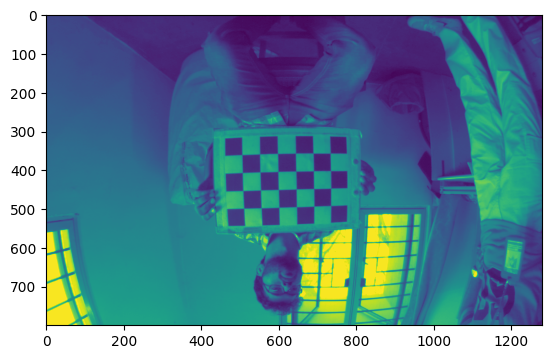

In [11]:
plt.imshow(_frame)

In [12]:
# for idx, frame in enumerate(tqdm(_video_data)):
def detectCorners(_frame):
    _frame = cv2.rotate(_frame.copy(), cv2.ROTATE_180)

    ret, corners = cv2.findChessboardCorners(_frame, patternSize)
    if ret:
        corners = cv2.cornerSubPix(
            _frame,
            corners,
            (5, 5),
            (-1, -1),
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001),
        )
    return corners
# Parallel execution with joblib
chessb_corners = []
results = Parallel(n_jobs=20, verbose=0)(
    delayed(detectCorners)(frame) for frame in tqdm(_video_data)
)
# Collect results
for result in results:
    if result is not None:
        chessb_corners.append(result)

0it [00:00, ?it/s]

In [13]:
# chessb_corners[0]

In [14]:
# Get the directory of the video file
video_dir = os.path.dirname(_video_pth)
corners_file = os.path.join(video_dir, "chessb_corners.msgpack")

with open(corners_file, "wb") as f:
    _packed_file = mp.packb(chessb_corners, default=mpn.encode)
    f.write(_packed_file)

# del(chessb_corners)

In [15]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined

In [1]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
np.random.seed(9)

In [2]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)

_webcam_calib_video = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_corners_pth = os.path.join(_webcam_calib_folder, "chessb_corners.msgpack")

In [3]:
# load data

_corners_file = open(_webcam_corners_pth, "rb")
chessb_corners = list(mp.Unpacker(_corners_file, object_hook=mpn.decode))
chessb_corners = chessb_corners[0]
chessb_corners = np.array(chessb_corners)

In [4]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 40
imgSize = (1200, 800)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)

In [5]:

def calibrate_single_iteration(_):
    rnd = np.random.choice(len(chessb_corners), 80)
    chessb_c = chessb_corners[rnd]
    worldPoints = []
    imagePoints = []

    for _f in chessb_c:
        imagePoints.append(_f)
        worldPoints.append(boardPoints)

    if useFisheye:
        flagsCalib = (
            cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
            + cv2.fisheye.CALIB_FIX_SKEW
            + cv2.fisheye.CALIB_CHECK_COND
        )
        calibrateCriteria = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            30,
            1e-12,
        )
        ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(
            np.expand_dims(np.asarray(worldPoints), -2),
            imagePoints,
            imgSize,
            None,
            None,
            flags=flagsCalib,
            criteria=calibrateCriteria,
        )
    else:
        flagsCalib = cv2.CALIB_RATIONAL_MODEL
        ret, cameraMatrix, k, R, t = cv2.calibrateCamera(
            worldPoints, imagePoints, imgSize, None, None, flags=flagsCalib
        )

    # print(worldPoints)
    return {"ReError": ret, "mat": cameraMatrix, "dist": k, "rvec": R, "tvec": t, 'rnd':rnd}


# Parallel execution with joblib
my_dict = {"ReError": [], "mat": [], "dist": [], "rvec": [], "tvec": [], 'rnd_value':[]}

results = Parallel(n_jobs=16, verbose=0)(
    delayed(calibrate_single_iteration)(_) for _ in tqdm(range(9000))
)
# Collect results
for result in results:
    my_dict["ReError"].append(result["ReError"])
    my_dict["mat"].append(result["mat"])
    my_dict["dist"].append(result["dist"])
    my_dict["rvec"].append(result["rvec"])
    my_dict["tvec"].append(result["tvec"])
    my_dict['rnd_value'].append(result['rnd'])


# calibrate_single_iteration(10)

  0%|          | 0/9000 [00:00<?, ?it/s]

In [6]:
# video_dir = os.path.dirname(_video_pth)
calibration_file = os.path.join(_webcam_calib_folder, "calibration_data_9000.msgpack")

with open(calibration_file, "wb") as f:
    _packed_file = mp.packb(my_dict, default=mpn.encode)
    f.write(_packed_file)

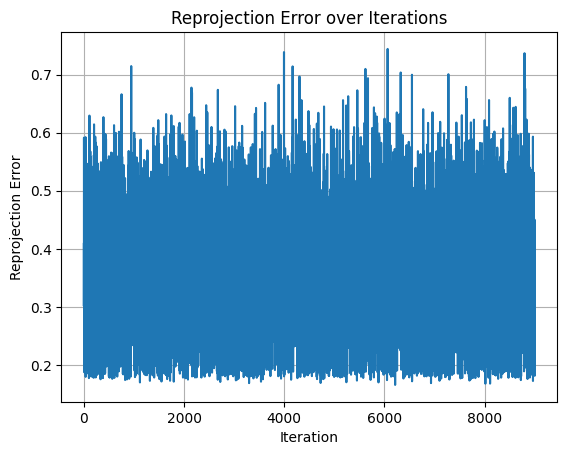

In [7]:
plt.plot(my_dict['ReError'])
plt.xlabel('Iteration')
plt.ylabel('Reprojection Error')
plt.title('Reprojection Error over Iterations')
plt.grid()

In [8]:
min_rerr_idx = np.argmin(my_dict['ReError'])
print('Minimum Reprojection Error:', my_dict['ReError'][min_rerr_idx], ' at index ', min_rerr_idx)

Minimum Reprojection Error: 0.16537513187360767  at index  6213


In [9]:
rerr = my_dict['ReError'][min_rerr_idx]
camera_mat = my_dict['mat'][min_rerr_idx]
camera_dist = my_dict['dist'][min_rerr_idx]

In [10]:
print(rerr, camera_mat, camera_dist)

0.16537513187360767 [[579.72859497   0.         653.35119909]
 [  0.         584.05827874 335.7158285 ]
 [  0.           0.           1.        ]] [[-0.02974416]
 [-0.00274131]
 [-0.00441237]
 [ 0.00135695]]


Translation Vector Standard Deviation: [192.87792094 123.27097866  83.78010211]


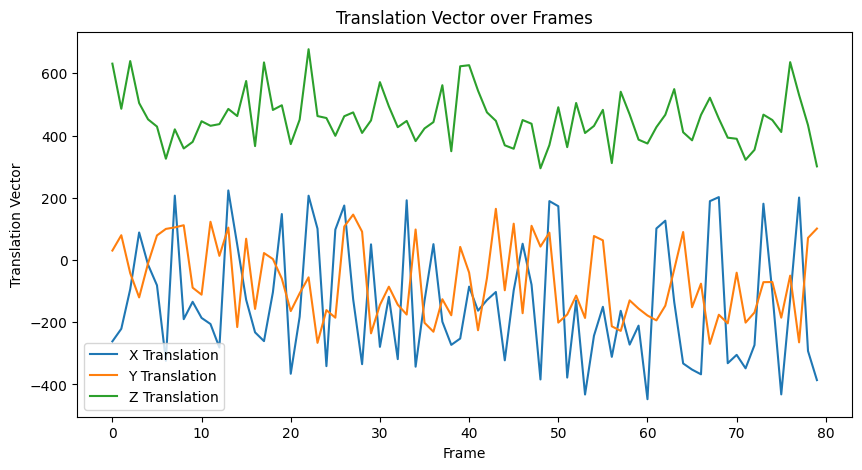

In [11]:
# plot the translation vector
tvec = my_dict['tvec'][0]
tvec = np.array(tvec).T[0]
plt.figure(figsize=(10, 5))
plt.plot(tvec[0], label='X Translation')
plt.plot(tvec[1], label='Y Translation')
plt.plot(tvec[2], label='Z Translation')
plt.xlabel('Frame')
plt.ylabel('Translation Vector')
plt.title('Translation Vector over Frames')
plt.legend()

# standard deviation of the translation vector
tvec_std = np.std(tvec, axis=1)
print('Translation Vector Standard Deviation:', tvec_std)

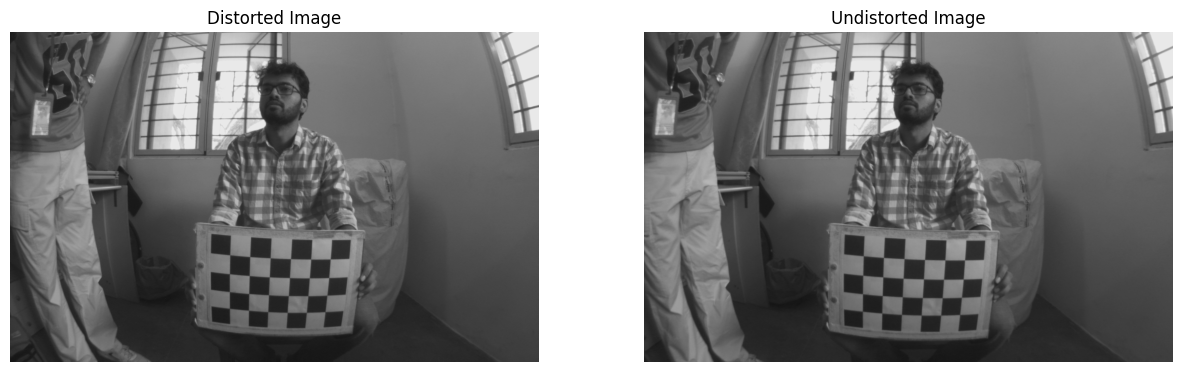

In [12]:
# show distorted and undistorted images
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
for idx, frame in enumerate(_video_data):
    # frame = cv2.flip(frame, 0)
    frame = cv2.rotate(frame, cv2.ROTATE_180)
    frame_undistorted = cv2.undistort(frame, camera_mat, camera_dist)
    # create a subplot with 2 images and break at first image and plot chessboard corners
    
    if idx == 0:
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('Distorted Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(frame_undistorted, cv2.COLOR_BGR2RGB))
        plt.title('Undistorted Image')
        plt.axis('off')
        plt.show()
        break

In [13]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined

# Analysis by using a second video

In [ ]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [ ]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"
_recording_folder_name = "randomxyz_t0"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)

_reference_recording_folder = os.path.join(
    _pth, '..', _parent_folder, "recordings",'160_fov','3marker_complete_data', _recording_folder_name
)
_reference_file = os.path.join(_reference_recording_folder, "webcam_color.msgpack")

# for loading 9000 values
_calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data_1000.msgpack')

# for loading just 100 points
_calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data_2000.msgpack')




In [ ]:
_ref_video_length = 0

for _ in mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode):
    _ref_video_length += 1

print('video length, ', _ref_video_length)

video length,  2861


In [ ]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36h11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients = np.zeros((5, 1))
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs, tvecs = [], []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            flags=cv2.SOLVEPNP_ITERATIVE,
        )
        if r is not None and t is not None:
            rvecs.append(r.reshape(1, 3).tolist())
            tvecs.append(t.reshape(1, 3).tolist())
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

## load clalibration data

In [ ]:
_calib_data = list(mp.Unpacker(open(_calibration_data, "rb"), object_hook=mpn.decode))

In [ ]:
# _calib_data[1]

In [ ]:
len(_calib_data[0]['ReError'])

2000

In [ ]:
# selecting random 50 frames
np.random.seed(9)
_random_reference_frames_idx = np.random.choice(_ref_video_length, 300)

_ref_data = mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode)

# _ref_frames = []

ar_total_results = {'calib_idx':[], 'ar_data':[]}
ar_results = {'corners': [], 'ids': [], 'rejected': []}
vector_std = {'v1std':[], 'v2std':[], 'v3std':[], 'sum':[], 
              'r1std':[], 'r2std':[], 'r3std':[], 'r_sum':[]}

for idx, _frame in tqdm(enumerate(_ref_data)):
    if idx in _random_reference_frames_idx:

        # _frame = cv2.rotate(_frame, cv2.ROTATE_180)
        _frame = cv2.flip(_frame, 1)
        res = detector.detectMarkers(_frame,)
        
        res = detector.refineDetectedMarkers(_frame, board, res[0], res[1], res[2])
        ar_results['corners'].append(res[0])
        ar_results['ids'].append(res[1])
        ar_results['rejected'].append(res[2])

    # if idx in _random_reference_frames_idx:
    #     _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    #     _ref_frames.append(_frame)


0it [00:00, ?it/s]

In [ ]:
# _frame = cv2.flip(_frame, 0)
# _frame = cv2.flip(_frame, 0)
# plt.imshow(_ref_frames[0])

In [ ]:
import numpy as np
from scipy import stats
from tqdm import tqdm
import cv2
from joblib import Parallel, delayed

# Define filtering functions outside the loop
def filter_90th_percentile_zscore(data, z_threshold=1.28):  # z=1.28 corresponds to ~90th percentile
    """Filter data to keep only values within 90th percentile using z-score"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    z_scores = np.abs(stats.zscore(data_clean))
    return data_clean[z_scores <= z_threshold]

def filter_90th_percentile_direct(data):
    """Filter data to keep only values up to 90th percentile"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    percentile_90 = np.percentile(data_clean, 90)
    return data_clean[data_clean <= percentile_90]

def process_single_calibration(idx, cal, ar_results):
    """Process a single calibration matrix"""
    mat = cal[0]
    dist = cal[1]
    
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        mat, dist, np.eye(3), mat, (1200, 800), cv2.CV_16SC2
    )
    new_matrix = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
        mat, dist, (1200, 800), None, None, cv2.CALIB_USE_INTRINSIC_GUESS
    )
    
    ordered_results = {'20': {'tvecs': [], 'rvecs': []},
                       '12': {'tvecs': [], 'rvecs': []},
                       '14': {'tvecs': [], 'rvecs': []}}
   
    vector_length = {'v1':[], 'v2':[], 'v3':[]}
    rvec_difference = {'r1':[], 'r2':[], 'r3':[]}
    
    for res in zip(ar_results['ids'], ar_results['corners']):
        undistorted_corners = []
        for marker_corner in res[1]:
            undistorted_corners.append(cv2.undistortPoints(marker_corner.reshape(-1, 1, 2), mat, dist))
        undistorted_corners = np.array(undistorted_corners)
        pose = estimate_pose_single_markers(res[1], 0.05, mat, dist)
        v_12, v_14, v_20 = np.zeros((1,3)), np.zeros((1,3)), np.zeros((1,3))
        r_12, r_14, r_20 = np.zeros((1,3)), np.zeros((1,3)), np.zeros((1,3))
        
        for idx_marker, id in enumerate(res[0].reshape(-1)):
            match id:
                case 20:
                    ordered_results['20']['tvecs'].append(pose[1][idx_marker])
                    ordered_results['20']['rvecs'].append(pose[0][idx_marker])
                    v_20 = pose[1][idx_marker]
                    r_20 = pose[0][idx_marker]
                case 12:
                    ordered_results['12']['tvecs'].append(pose[1][idx_marker])
                    ordered_results['12']['rvecs'].append(pose[0][idx_marker])
                    v_12 = pose[1][idx_marker]
                    r_12 = pose[0][idx_marker]
                case 14:
                    ordered_results['14']['tvecs'].append(pose[1][idx_marker])
                    ordered_results['14']['rvecs'].append(pose[0][idx_marker])
                    v_14 = pose[1][idx_marker]
                    r_14 = pose[0][idx_marker]
                case _:
                    continue
       
        # Calculate vector lengths
        vector_length['v1'].append(np.linalg.norm(v_12 - v_14))
        vector_length['v2'].append(np.linalg.norm(v_14 - v_20))
        vector_length['v3'].append(np.linalg.norm(v_20 - v_12))
        
        rvec_difference['r1'].append(np.sum(r_12 - r_14))
        rvec_difference['r2'].append(np.sum(r_14 - r_20))
        rvec_difference['r3'].append(np.sum(r_20 - r_12))
   
    # Apply filtering to each vector length array
    v1_filtered = filter_90th_percentile_direct(vector_length['v1'])
    v2_filtered = filter_90th_percentile_direct(vector_length['v2'])
    v3_filtered = filter_90th_percentile_direct(vector_length['v3'])
    
    r1_filtered = filter_90th_percentile_direct(rvec_difference['r1'])
    r2_filtered = filter_90th_percentile_direct(rvec_difference['r2'])
    r3_filtered = filter_90th_percentile_direct(rvec_difference['r3'])
    
    # Calculate standard deviation on filtered data
    v1_std_val = np.nanstd(v1_filtered) if len(v1_filtered) > 0 else np.nan
    v2_std_val = np.nanstd(v2_filtered) if len(v2_filtered) > 0 else np.nan
    v3_std_val = np.nanstd(v3_filtered) if len(v3_filtered) > 0 else np.nan
    
    r1_std_val = np.nanstd(r1_filtered) if len(r1_filtered) > 0 else np.nan
    r2_std_val = np.nanstd(r2_filtered) if len(r2_filtered) > 0 else np.nan
    r3_std_val = np.nanstd(r3_filtered) if len(r3_filtered) > 0 else np.nan
    
    # Sum of standard deviations
    v1_std_final = v1_std_val if not np.isnan(v1_std_val) else 0
    v2_std_final = v2_std_val if not np.isnan(v2_std_val) else 0
    v3_std_final = v3_std_val if not np.isnan(v3_std_val) else 0
    
    r1_std_final = r1_std_val if not np.isnan(r1_std_val) else 0
    r2_std_final = r2_std_val if not np.isnan(r2_std_val) else 0
    r3_std_final = r3_std_val if not np.isnan(r3_std_val) else 0
    
    sum_std = v1_std_final + v2_std_final + v3_std_final
    r_sum_std = r1_std_final + r2_std_final + r3_std_final
    
    
    return {
        'calib_idx': idx,
        'ar_data': ordered_results,
        'v1std': v1_std_val,
        'v2std': v2_std_val,
        'v3std': v3_std_val,
        'sum': sum_std,
        
        'r1std': r1_std_val,
        'r2std': r2_std_val,
        'r3std': r3_std_val,
        'r_sum': r_sum_std
    }

# Parallel processing of calibration matrices
print("Processing calibration matrices in parallel...")
calibration_data = list(zip(_calib_data[0]['mat'], _calib_data[0]['dist']))

# Use joblib to parallelize calibration processing
# n_jobs=-1 uses all available cores, you can set specific number like n_jobs=4
results = Parallel(n_jobs=20, verbose=1)(
    delayed(process_single_calibration)(idx, cal, ar_results) 
    for idx, cal in enumerate(tqdm(calibration_data, desc="Preparing calibration jobs"))
)

# Collect results
for result in results:
    ar_total_results['calib_idx'].append(result['calib_idx'])
    ar_total_results['ar_data'].append(result['ar_data'])
    vector_std['v1std'].append(result['v1std'])
    vector_std['v2std'].append(result['v2std'])
    vector_std['v3std'].append(result['v3std'])
    vector_std['sum'].append(result['sum'])
    vector_std['r1std'].append(result['r1std'])
    vector_std['r2std'].append(result['r2std'])
    vector_std['r3std'].append(result['r3std'])
    vector_std['r_sum'].append(result['r_sum'])

Processing calibration matrices in parallel...


Preparing calibration jobs: 100%|██████████| 2000/2000 [01:16<00:00, 26.10it/s]
[Parallel(n_jobs=20)]: Done 2000 out of 2000 | elapsed:  1.3min finished


In [ ]:
_optimization_file = os.path.join(_webcam_calib_folder, "optimization_file_2000r.msgpack")

with open(_optimization_file, "wb") as f:
    _packed_file = mp.packb([ar_total_results, vector_std], default=mpn.encode)
    f.write(_packed_file)

In [ ]:
print('v1_std',np.argmin(vector_std['v1std']), vector_std['v1std'][np.argmin(vector_std['v1std'])])
print('v2_std',np.argmin(vector_std['v2std']), vector_std['v2std'][np.argmin(vector_std['v2std'])])
print('v2_std',np.argmin(vector_std['v3std']), vector_std['v3std'][np.argmin(vector_std['v3std'])])
print('r1_std',np.argmin(vector_std['r1std']), vector_std['r1std'][np.argmin(vector_std['r1std'])])
print('r2_std',np.argmin(vector_std['r2std']), vector_std['r2std'][np.argmin(vector_std['r2std'])])
print('r3_std',np.argmin(vector_std['r3std']), vector_std['r3std'][np.argmin(vector_std['r3std'])])
print('v_sum ',np.argmin(vector_std['sum']), vector_std['sum'][np.argmin(vector_std['sum'])])
print('r_sum ',np.argmin(vector_std['r_sum']), vector_std['r_sum'][np.argmin(vector_std['r_sum'])])

v1_std 706 0.0009589368
v2_std 40 0.0018474423759688066
v2_std 1967 0.0007412803205119383
r1_std 450 1.1394773
r2_std 523 0.3862228754251427
r3_std 295 0.505526384588242
v_sum  1625 0.003737009245219633
r_sum  1635 3.362950353141817


In [ ]:
_vector_std_ul = vector_std['sum'] / np.linalg.norm(vector_std['sum'])
_r_std_ul = vector_std['r_sum'] / np.linalg.norm(vector_std['r_sum'])

np.argmin((_vector_std_ul + _r_std_ul))

np.int64(40)

In [ ]:
_calib_data[0].keys()

dict_keys(['ReError', 'mat', 'dist', 'rvec', 'tvec', 'rnd_value'])

In [ ]:
np.argmin(_calib_data[0]['ReError'])

np.int64(1470)

In [ ]:
print(_calib_data[0]['mat'][10])
print(_calib_data[0]['dist'][10])

[[583.74894761   0.         655.62169261]
 [  0.         587.45257362 334.63280683]
 [  0.           0.           1.        ]]
[[-0.0454573 ]
 [ 0.04474313]
 [-0.06101144]
 [ 0.0247249 ]]


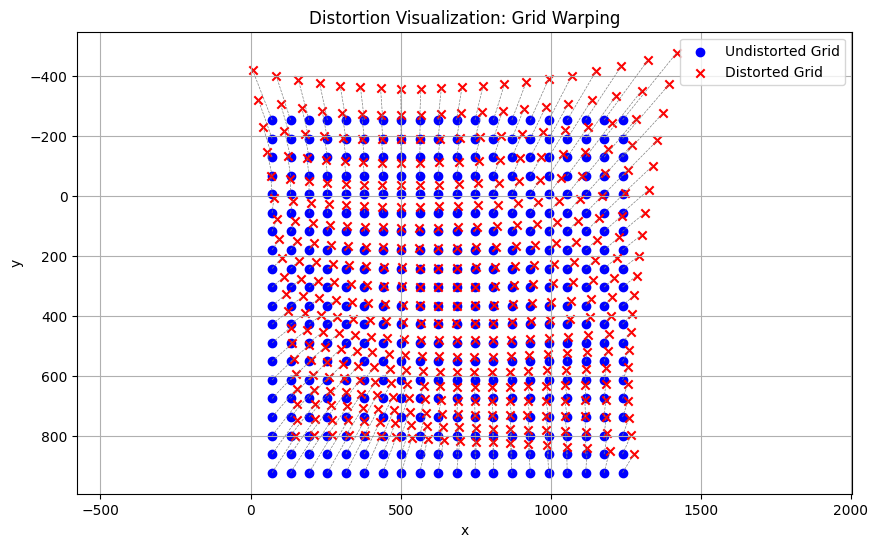

In [ ]:
# K = _calib_data[0]['mat'][np.argmin(_calib_data[0]['ReError'])]
# D = _calib_data[0]['dist'][np.argmin(_calib_data[0]['ReError'])]

K = _calib_data[0]['mat'][10]
D = _calib_data[0]['dist'][10]

# Grid size and image size
grid_size = 20
image_size = (1200, 800)

# Generate a regular grid in normalized object space (X, Y, Z)
x_vals = np.linspace(-1, 1, grid_size)
y_vals = np.linspace(-1, 1, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
zz = np.ones_like(xx)  # Place all points at Z = 1

# Stack into 3D object points (N, 3)
object_points = np.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=-1).astype(np.float32)

# Identity rotation and zero translation (camera at origin)
rvec = np.zeros(3, dtype=np.float32)
tvec = np.zeros(3, dtype=np.float32)

# Project undistorted (ideal) and distorted image points
undistorted_points, _ = cv2.projectPoints(object_points, rvec, tvec, K, np.zeros_like(D))
distorted_points, _ = cv2.projectPoints(object_points, rvec, tvec, K, D)

undistorted_points = undistorted_points.reshape(-1, 2)
distorted_points = distorted_points.reshape(-1, 2)

# ---------- Plotting ----------
plt.figure(figsize=(10, 6))
plt.scatter(undistorted_points[:, 0], undistorted_points[:, 1], color='blue', label='Undistorted Grid')
plt.scatter(distorted_points[:, 0], distorted_points[:, 1], color='red', label='Distorted Grid', marker='x')
for pt1, pt2 in zip(undistorted_points, distorted_points):
    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='gray', linestyle='--', linewidth=0.5)

plt.title('Distortion Visualization: Grid Warping')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.legend()
plt.grid(True)
# plt.xlim(0, image_size[0])
# plt.ylim(image_size[1], 0)
plt.show()


In [ ]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined